In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 11})
import json
import re
import nltk
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC,SVC
from sklearn.feature_selection import SelectKBest,chi2
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.utils.multiclass import unique_labels
from math import ceil, floor

In [2]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;-]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))
Number_RE = re.compile('[*^0-9]')
Bad_underline = re.compile('[*_*]')
RemoveTag = re.compile('x\\b')
def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
#     text = BeautifulSoup(text)
    text = text.lower() # lowercase text
    text = RemoveTag.sub('',text)
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = Number_RE.sub(' ', text) # replace Number symbols by space in text
    text = Bad_underline.sub(' ', text) # replace Underline symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text
    return text

def print_plot(index,data):
    example = data[data.index == index][['id', 'category','description']].values[0]
    if len(example) > 0:
        print('Unique ID :',example[0])
        print('------------------------')
        print('Class:'+ example[1])
        print('------------------------')
        print('Description:', example[2])
        print('------------------------')
        print('Description:', clean_text(example[2]))


In [3]:
def classNumberThreshold(arr):
    dropCategory = []

    for key,value in arr.items():
        if(value<=10):
            dropCategory.append(key)
    return dropCategory

In [4]:


data = pd.read_csv('../example/real.csv')
data = pd.DataFrame({'id':data['JobNumber'],'Name':data['JobName'],'RWCategory':data['RW Category'],'category':data['RW Job Type'],'description':data['Details']})
data = data[data['RWCategory']=='Freeformat Text']
data = data.drop(columns=['RWCategory'])
data = data[pd.notnull(data['description'])]
data.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 562 entries, 0 to 950
Data columns (total 4 columns):
id             562 non-null object
Name           562 non-null object
category       562 non-null object
description    562 non-null object
dtypes: object(4)
memory usage: 22.0+ KB


In [5]:
data.category.value_counts()

Leaflet                      75
DPLM                         71
POS                          70
Mail Pack                    64
Promo                        62
Posters                      50
Booklet                      43
Letter                       34
Suppressions                 29
Envelope                     19
Postage                      13
Folder                        9
Stickers                      4
Deliveries                    3
Dividers & Content Sheets     2
Die Forms                     2
Business Cards                2
Data charges                  2
NCR Pad                       1
Cheque Pouch                  1
Christmas Card                1
Pollywrap                     1
Pad                           1
Plastic Cards                 1
Passbook                      1
Artwork                       1
Name: category, dtype: int64

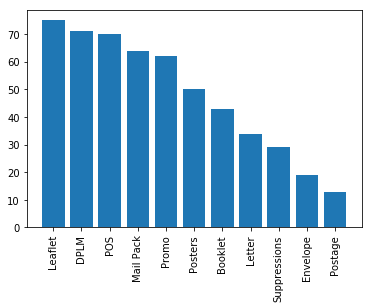

In [6]:
dropClass = classNumberThreshold(data.category.value_counts())
for ele in dropClass:
    data = data[data['category']!=ele]

value_count = data.category.value_counts()
fig, axs = plt.subplots()
axs.bar(value_count.index, value_count.values)
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)
fig.savefig("C/dataDistribution.png")

In [7]:
print_plot(10,data)
data.info()

Unique ID : J/2690
------------------------
Class:Posters
------------------------
Description: A1 - 1pp||Printed full colour||170gsm Silk||Trim to size||Supplied in bulk, flat on pallets and separated by kind||||11-0517ABCD	Brand ISA Campaign - Lead Brand Savings 4xA1 poster sets x 180 sets of 4||11-0518	Brand ISA Campaign - Lead Brand Savings single A1 posters x 260||11-0519ABCD	Brand ISA Campaign - Support Brand ISA 4xA1 poster sets	x 150 sets of 4||11-0520	Brand ISA Campaign - Support Brand ISA single A1 posters x 180||11-0522	Brand ISA Campaign - LISA Internal Single A1 poster x 280||11-0523	Brand ISA Campaign - Internal Colleague Poster 1 x 190||11-0524	Brand ISA Campaign - Internal Colleague Poster 2 x 190
------------------------
Description: pp printed full colour gsm silk trim size supplied bulk flat pallets separated kind abcdbrand isa campaign lead brand savings xa poster sets sets brand isa campaign lead brand savings single posters abcdbrand isa campaign support brand isa

In [8]:
X = data.description.apply(clean_text)
tfidfconverter = TfidfVectorizer(min_df=5, max_df=0.7,ngram_range=(1,3))
X = tfidfconverter.fit_transform(X)
total_feature = X.shape[1]

le = LabelEncoder()
le.fit(data.category)
target = le.classes_
labels = le.transform(data.category)
y = pd.DataFrame({'id':data.id,'category':labels,'categoryName':target[labels],'originText':data.description.apply(clean_text)})

In [9]:
X_train, X_test, yTrain, yTest = train_test_split(X, y, test_size=0.2, random_state = 27)
y_train = yTrain.category
y_test = yTest.category

In [10]:
len(y_train), len(y_test)

(424, 106)

In [11]:
from keras.preprocessing.text import Tokenizer
data = yTrain.originText
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data)
sequences = tokenizer.texts_to_sequences(data)
trainlengths = [len(ele) for ele in sequences]
max(trainlengths), np.mean(trainlengths)

Using TensorFlow backend.


(86, 20.471698113207548)

In [12]:
scores = []
nums = []
print("Total features: "+ str(total_feature))
for num in range(50,total_feature,50):
    selectBest = SelectKBest(chi2, k=num).fit(X_train, y_train)
    Xtrainbest = selectBest.transform(X_train)
    Xtestbest = selectBest.transform(X_test)
    model = LinearSVC(random_state=42,class_weight="balanced")
    model.fit(Xtrainbest,y_train)
    score = model.score(Xtestbest,y_test)
    scores.append(score)
    nums.append(num)

index = np.argmax(scores)
print("Best size: "+ str(nums[index]) + " Best accuracy: "+ str(max(scores))) 
    

Total features: 1189
Best size: 800 Best accuracy: 0.9339622641509434


In [13]:
selectBest = SelectKBest(chi2, k=nums[index]).fit(X_train, y_train)
Xtrainbest = selectBest.transform(X_train)
Xtestbest = selectBest.transform(X_test)

In [14]:
model = LinearSVC(random_state=42,class_weight="balanced")

In [15]:

%time
# 5.01
model.fit(Xtrainbest,y_train)


CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 9.78 µs


LinearSVC(C=1.0, class_weight='balanced', dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
     verbose=0)

In [16]:
coef = model.coef_
y_confidence = model.decision_function(Xtestbest)



In [17]:
%time
y_pred = model.predict(Xtestbest)
# 5.01


CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 8.11 µs


In [18]:
print(classification_report(y_test, y_pred,target_names=target))

# with open('C/Score.txt', 'w') as file:
#     file.write(classification_report(y_test, y_pred,target_names=target))

              precision    recall  f1-score   support

     Booklet       0.86      1.00      0.92         6
        DPLM       1.00      1.00      1.00        11
    Envelope       1.00      1.00      1.00         4
     Leaflet       0.83      1.00      0.91        10
      Letter       1.00      1.00      1.00         8
   Mail Pack       1.00      0.93      0.96        14
         POS       0.88      0.83      0.86        18
     Postage       1.00      1.00      1.00         1
     Posters       1.00      0.94      0.97        16
       Promo       0.85      0.85      0.85        13
Suppressions       1.00      1.00      1.00         5

   micro avg       0.93      0.93      0.93       106
   macro avg       0.95      0.96      0.95       106
weighted avg       0.94      0.93      0.93       106



In [19]:
cm = confusion_matrix(y_test, y_pred)

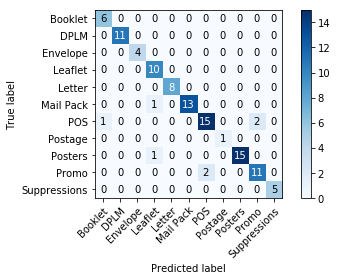

In [20]:
fig, ax = plt.subplots()
im =ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
classes = target[unique_labels(y_test, y_pred)]
# We want to show all ticks...
ax.set(xticks=np.arange(cm.shape[1]),yticks=np.arange(cm.shape[0]),
       # ... and label them with the respective list entries
        xticklabels=classes, yticklabels=classes,ylabel='True label',xlabel='Predicted label')
# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
fmt = 'd'
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),ha="center", va="center", color="white" if cm[i, j] > thresh else "black")
fig.tight_layout()
# fig.savefig("C/confusionMatrix.png")

In [21]:

featureName = tfidfconverter.get_feature_names()

Max = ceil(max(selectBest.scores_))
Min = floor(min(selectBest.scores_))

Normscores = [round((ele-Min)/(Max-Min),2) for ele in selectBest.scores_]

Scores = list(zip(selectBest.get_support(),Normscores))

ScoreDict = dict(zip(featureName,Scores))

NewScoreDict = {}

for key , item in ScoreDict.items():
    if(item[0]):
        NewScoreDict[key] = item[1]

RanksdataNewScoreDict = pd.DataFrame({"feature":list(NewScoreDict.keys()),"Score":list(NewScoreDict.values())},dtype=np.int64)
RanksdataNewScoreDict = RanksdataNewScoreDict.sort_values(by=['Score'],ascending=False)
RanksdataNewScoreDict.to_csv("C/RankByTotalFeature2gram.csv",index=False,compression=None)



In [22]:

classWithInfluence = {}
coef = scale(coef)
coefTotalSize = coef.shape[0]*coef.shape[1]
Max = ceil(max(coef.reshape(coefTotalSize,1))[0])
Min = floor(min(coef.reshape(coefTotalSize,1))[0])
for index in range(0,len(coef)):
    normalisedCoef = [round((ele-Min)/(Max-Min),2) for ele in coef[index]]
    name = list(NewScoreDict.keys())
    classWithInfluence[target[index]] = list(zip(name,normalisedCoef))


In [23]:
classWithInfluence

{'Booklet': [('ab', 0.45),
  ('ab samples', 0.45),
  ('ab samples required', 0.48),
  ('abg', 0.5),
  ('abg silver', 0.5),
  ('abg silver snap', 0.5),
  ('account', 0.46),
  ('account ab', 0.47),
  ('account ab samples', 0.47),
  ('account please', 0.48),
  ('account please supply', 0.48),
  ('address block', 0.47),
  ('adhesive', 0.48),
  ('admail', 0.48),
  ('admail sus', 0.47),
  ('admail sus entry', 0.52),
  ('adviser', 0.44),
  ('adviser mailing', 0.44),
  ('adviser mailing pp', 0.44),
  ('ark', 0.6),
  ('ark bedford', 0.32),
  ('artwork print', 0.44),
  ('artwork print ready', 0.44),
  ('back', 0.47),
  ('badge', 0.5),
  ('bag', 0.49),
  ('balance', 0.51),
  ('balance ark', 0.82),
  ('balance ark bedford', 0.3),
  ('banner', 0.49),
  ('banner printed', 0.49),
  ('banner printed full', 0.49),
  ('bedford', 0.32),
  ('bk', 0.48),
  ('bk trim', 0.5),
  ('bk trim fold', 0.5),
  ('black', 0.47),
  ('black face', 0.48),
  ('black face gsm', 0.44),
  ('black one', 0.64),
  ('bleed', 0.4

In [24]:
EachFile = {}
for key, value in classWithInfluence.items():
    EachFeatureNames = []
    EachFeatureScores = []
    for e in value:
        EachFeatureNames.append(e[0])
        EachFeatureScores.append(e[1])
    EachFile[key] = [EachFeatureNames,EachFeatureScores]

for key, value in EachFile.items():
    pd.DataFrame({'Names':value[0], 'Score':value[1]}).to_csv('C/'+key+'.csv')


In [25]:
Top10InflunceFeature = {}
for key, value in classWithInfluence.items():
    Top10InflunceFeature[key] = sorted(value, key=lambda x: x[1], reverse=True)[:10]

with open('C/CompanyTopFeatureByClass2gram.txt', 'w') as json_file:
    json.dump(Top10InflunceFeature, json_file)    
    


In [26]:
total = y_confidence.shape[0]*y_confidence.shape[1]
Max = 2
Min = -2
confidence1 = [round(((max(ele)-Min)/(Max-Min)),2) for ele in y_confidence]

In [27]:
testData = pd.DataFrame({'id':  yTest.id,'description':yTest.originText,'trueClass': y_test,'trueClassNaem':yTest.categoryName ,'predictClass':y_pred,'predictClassName':target[y_pred], 'Confidence':confidence1})

In [28]:
testData.to_csv("C/result.csv",index=False,compression=None)

In [29]:
num = []
totalitems = []
correct = []
incorrect = []
for ele in range(20,81,2):
    ele = ele*0.01
    data = testData[testData['Confidence']>ele]
    numberCorrect = len(data[data['trueClass']==data['predictClass']].index)
    numberIncorrect = len(data[data['trueClass']!=data['predictClass']].index)
    numItem = len(data.index)
    totalitems.append(numItem)
    num.append(ele)
    correct.append(numberCorrect)
    incorrect.append(numberIncorrect)

In [30]:
ClassfiedProportion = [ ele/len(testData.index) for ele in totalitems]

Acc =[]
for ele in zip(correct,totalitems):
    if (ele[1]==0):
        Acc.append(0)
    else:
        Acc.append(ele[0]/ele[1])


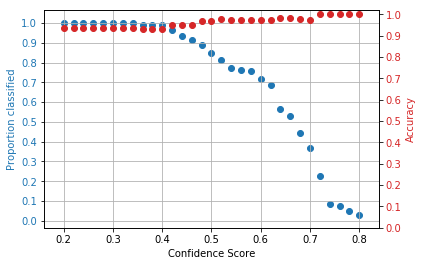

In [31]:
fig,ax  = plt.subplots()
color = 'tab:blue'

ax.scatter(num,ClassfiedProportion,label="Proportion classified",color=color)

ax.set_xlabel("Confidence Score")
ax.set_ylabel("Proportion classified", color=color)
ax.xaxis.set_ticks(np.arange(0,1.1,0.1))
ax.yaxis.set_ticks(np.arange(0,1.1,0.1))
ax.tick_params(axis='y', labelcolor=color)
ax.yaxis.set_ticks(np.arange(0,1.1,0.1))

color = 'tab:red'

ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis

ax2.scatter(num,Acc,label="Accuracy", color=color)
ax2.set_ylabel("Accuracy", color=color)
ax2.yaxis.set_ticks(np.arange(0,1.1,0.1))
ax2.tick_params(axis='y', labelcolor=color)

ax.grid()
# fig.savefig("C/ConfidenceScore.png")

In [35]:
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier(n_estimators=200, learning_rate=1.0, 
                                 max_depth=1, random_state=0).fit(Xtrainbest, y_train)
y_pred = clf.predict(Xtestbest)
print(classification_report(y_test, y_pred,target_names=target))


              precision    recall  f1-score   support

     Booklet       1.00      0.67      0.80         6
        DPLM       1.00      1.00      1.00        11
    Envelope       0.80      1.00      0.89         4
     Leaflet       0.35      0.70      0.47        10
      Letter       1.00      1.00      1.00         8
   Mail Pack       1.00      0.93      0.96        14
         POS       0.93      0.72      0.81        18
     Postage       0.50      1.00      0.67         1
     Posters       0.93      0.81      0.87        16
       Promo       0.60      0.46      0.52        13
Suppressions       1.00      1.00      1.00         5

   micro avg       0.80      0.80      0.80       106
   macro avg       0.83      0.84      0.82       106
weighted avg       0.85      0.80      0.82       106



In [51]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(solver='lbfgs',activation='tanh', alpha=1e-5, hidden_layer_sizes=(300, 300), random_state=1).fit(Xtrainbest, y_train)
y_pred = clf.predict(Xtestbest)
print(classification_report(y_test, y_pred,target_names=target))

              precision    recall  f1-score   support

     Booklet       1.00      0.67      0.80         6
        DPLM       1.00      1.00      1.00        11
    Envelope       0.57      1.00      0.73         4
     Leaflet       0.62      0.80      0.70        10
      Letter       1.00      1.00      1.00         8
   Mail Pack       1.00      0.93      0.96        14
         POS       0.87      0.72      0.79        18
     Postage       1.00      1.00      1.00         1
     Posters       1.00      0.94      0.97        16
       Promo       0.75      0.69      0.72        13
Suppressions       0.71      1.00      0.83         5

   micro avg       0.86      0.86      0.86       106
   macro avg       0.87      0.89      0.86       106
weighted avg       0.88      0.86      0.86       106

